In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from scipy import stats
from mne.viz import circular_layout, plot_connectivity_circle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import pyreadstat

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
# functions to transform vector to dfnc matrix
def calc_num_components(a):
    num_pairs = len(a)
    num_components = int(np.ceil(np.sqrt(2 * num_pairs - 1)))
    if num_components * (num_components - 1) == 2 * num_pairs:
        return num_components
    else:
        return 0


def return_dfnc_from_vector(a):
    '''This Function returns a dfnc matrix given a vector
        a : the vector of correlation pairs
    '''
    n = calc_num_components(a)
    out = np.zeros((n, n))

    if not n:
        return out
    
    l_indices = np.tril_indices(n, -1)
    u_indices = np.triu_indices(n, 1)

    out[u_indices] = a
    out[l_indices] = out.T[l_indices]
    
    return out

In [3]:
# functions to transform vector to dfnc matrix
n_subjects = 48
n_controls = 17
n_controls_1 = 16
n_patients = 31
n_windows = 159
n_corr = 78

In [4]:
# index of subgroups: worse == ARAT < 29; better == ARAT > 28 
worse= [34, 28, 19, 33, 42, 37, 25, 29, 27, 45, 46, 17, 31] 
better = [36, 38,35, 40, 41, 43,  39,  32, 18, 30, 26, 24, 23, 22, 21, 20, 44, 47] 

In [5]:
# correct indexing when having behavior of stroke patients only (excluding 17 controls)
worse_zero = np.subtract(worse,17)
better_zero = np.subtract(better,17)

# array indicating worse or better functional status
subgroups = np.ones(31)
subgroups[worse_zero] = 2

In [6]:
sfnc = loadmat('sfnc_corrs.mat')["static"]
sfnc = pd.DataFrame(sfnc)

In [7]:
# Define subgroups
sfnc_controls = sfnc[0:n_controls]
sfnc_patients = sfnc[n_controls:]
sfnc_patients_better = sfnc.loc[better]
sfnc_patients_worse = sfnc.loc[worse]

In [8]:
# One-way ANOVAS
p_all_ANOVA = []
for n in range(0,np.shape(sfnc)[1]):
    p_all_ANOVA.append(stats.f_oneway(sfnc_controls.loc[:,n], sfnc_patients_better.loc[:,n], sfnc_patients_worse.loc[:,n])[1])

In [9]:
uncorrected_ANOVA = pd.DataFrame(return_dfnc_from_vector(p_all_ANOVA))
#uncorrected_ANOVA

In [10]:
# t-test controls vs moderate stroke
p_all_better = []
for n in range(0,np.shape(sfnc)[1]):
    rvs1 = sfnc_controls.loc[:,n]
    rvs2 = sfnc_patients_better.loc[:,n]
    p_all_better.append(stats.ttest_ind(rvs1,rvs2)[1])

In [11]:
uncorrected_better = pd.DataFrame(return_dfnc_from_vector(p_all_better))
#uncorrected_better

In [12]:
# t-test controls vs severe stroke
p_all_worse = []
for n in range(0,np.shape(sfnc)[1]):
    rvs1 = sfnc_controls.loc[:,n]
    rvs2 = sfnc_patients_worse.loc[:,n]
    p_all_worse.append(stats.ttest_ind(rvs1,rvs2)[1])

In [13]:
uncorrected_worse = pd.DataFrame(return_dfnc_from_vector(p_all_worse))
#uncorrected_worse

In [14]:
# t-test moderate vs severe stroke
p_all_better_worse = []
for n in range(0,np.shape(sfnc)[1]):
    rvs1 = sfnc_patients_better.loc[:,n]
    rvs2 = sfnc_patients_worse.loc[:,n]
    p_all_better_worse.append(stats.ttest_ind(rvs1,rvs2)[1])

In [15]:
uncorrected_bw = pd.DataFrame(return_dfnc_from_vector(p_all_better_worse))
#uncorrected_bw

In [16]:
# SNFNC
mask = np.zeros_like(uncorrected_better*(uncorrected_ANOVA<0.05), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True


bw_p = uncorrected_bw*(uncorrected_ANOVA<0.05)*mask
bw_p = np.ravel(bw_p[bw_p!=0])
bw_p = bw_p[~np.isnan(bw_p)]
better_p = uncorrected_better*(uncorrected_ANOVA<0.05)*mask
better_p = np.ravel(better_p[better_p!=0])
better_p = better_p[~np.isnan(better_p)]
worse_p = uncorrected_worse*(uncorrected_ANOVA<0.05)*mask
worse_p = np.ravel(worse_p[worse_p!=0])
worse_p = worse_p[~np.isnan(worse_p)]

In [17]:
statsmodels.stats.multitest.multipletests(np.concatenate((better_p, worse_p, bw_p,)), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

(array([ True,  True, False, False,  True,  True, False,  True,  True,
         True, False, False,  True,  True, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 array([3.35520976e-02, 3.22704941e-02, 6.93554708e-02, 6.83138247e-01,
        4.14795869e-02, 3.95039462e-02, 5.20411381e-02, 3.22704941e-02,
        3.35520976e-02, 3.35520976e-02, 5.54919936e-02, 9.46290491e-02,
        3.22704941e-02, 3.22704941e-02, 5.54919936e-02, 5.20411381e-02,
        4.01879932e-02, 5.20411381e-02, 1.25581293e-01, 2.64209347e-01,
        8.83442288e-01, 5.75249624e-02, 1.66743182e-01, 3.23004809e-01,
        8.91504189e-01, 9.46290491e-02, 7.17007903e-02, 9.46290491e-02,
        9.75515911e-02, 3.49147992e-04, 1.82204933e-01, 4.79314917e-

In [18]:
# absolute
connectivity_diff_better = pd.DataFrame(return_dfnc_from_vector(np.absolute(sfnc_patients_better.median())-np.absolute(sfnc_controls.median())))
connectivity_diff_worse = pd.DataFrame(return_dfnc_from_vector(np.absolute(sfnc_patients_worse.median())-np.absolute(sfnc_controls.median())))

In [19]:
np.sum(uncorrected_worse*(uncorrected_worse<0.01)!=0).sum()

4

In [20]:
significant_connectivity_better = connectivity_diff_better*(uncorrected_better<0.01)
significant_connectivity_worse = connectivity_diff_worse*(uncorrected_worse<0.01)

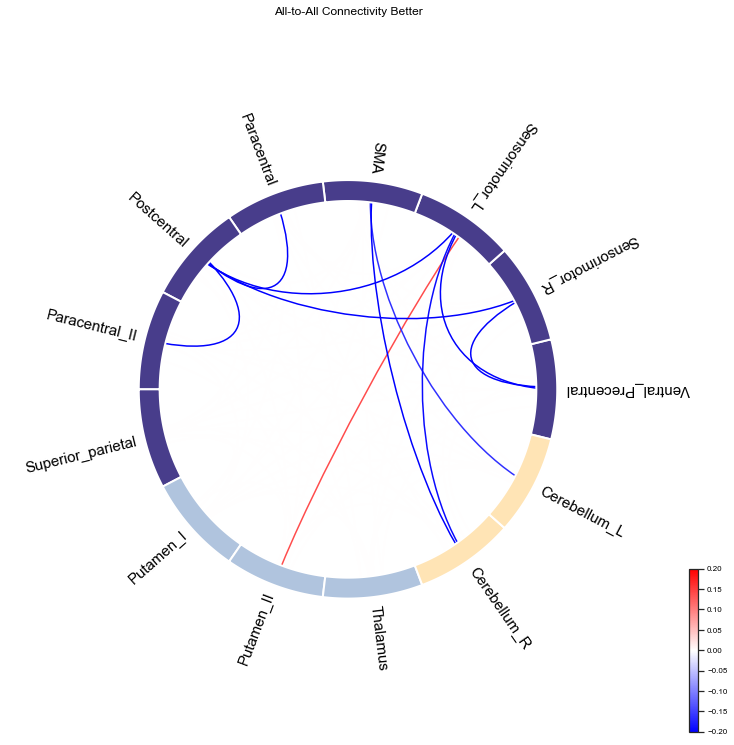

In [21]:
label_names = ["Ventral_Precentral","Sensorimotor_R","Sensorimotor_L","SMA","Paracentral","Postcentral","Paracentral_II","Superior_parietal","Putamen_I","Putamen_II","Thalamus","Cerebellum_R","Cerebellum_L",]
fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
node_colors = ["darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","lightsteelblue","lightsteelblue","lightsteelblue","moccasin","moccasin"]
plot_connectivity_circle(np.array(significant_connectivity_better), label_names, node_colors=node_colors,node_edgecolor="white",colormap="bwr",facecolor="white",textcolor="black", vmin=-0.2, vmax=0.2, n_lines=500, fontsize_names=15, title='All-to-All Connectivity Better', fig=fig)
plt.show()
#fig.savefig("SFNC_sign_connectivity_better_2_0708.png", dpi=600)


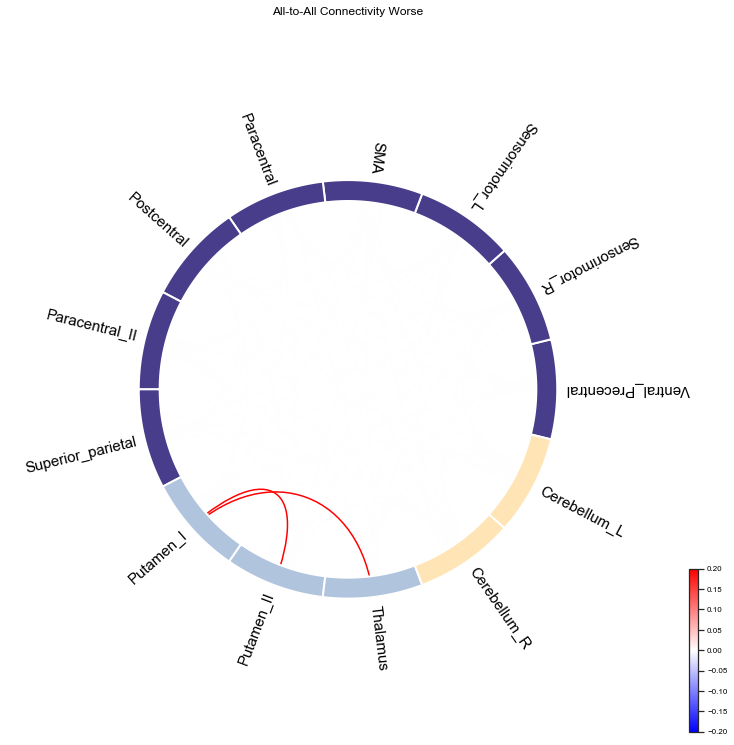

In [22]:
label_names = ["Ventral_Precentral","Sensorimotor_R","Sensorimotor_L","SMA","Paracentral","Postcentral","Paracentral_II","Superior_parietal","Putamen_I","Putamen_II","Thalamus","Cerebellum_R","Cerebellum_L",]
fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
node_colors = ["darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","lightsteelblue","lightsteelblue","lightsteelblue","moccasin","moccasin"]
plot_connectivity_circle(np.array(significant_connectivity_worse), label_names, node_colors=node_colors,node_edgecolor="white",colormap="bwr",facecolor="white",textcolor="black", vmin=-0.2, vmax=0.2, n_lines=500, fontsize_names=15, title='All-to-All Connectivity Worse', fig=fig)
plt.show()
#fig.savefig("SFNC_sign_connectivity_worse_2_0708.png", dpi=600)
